# LangChain Expression Language (LCEL)

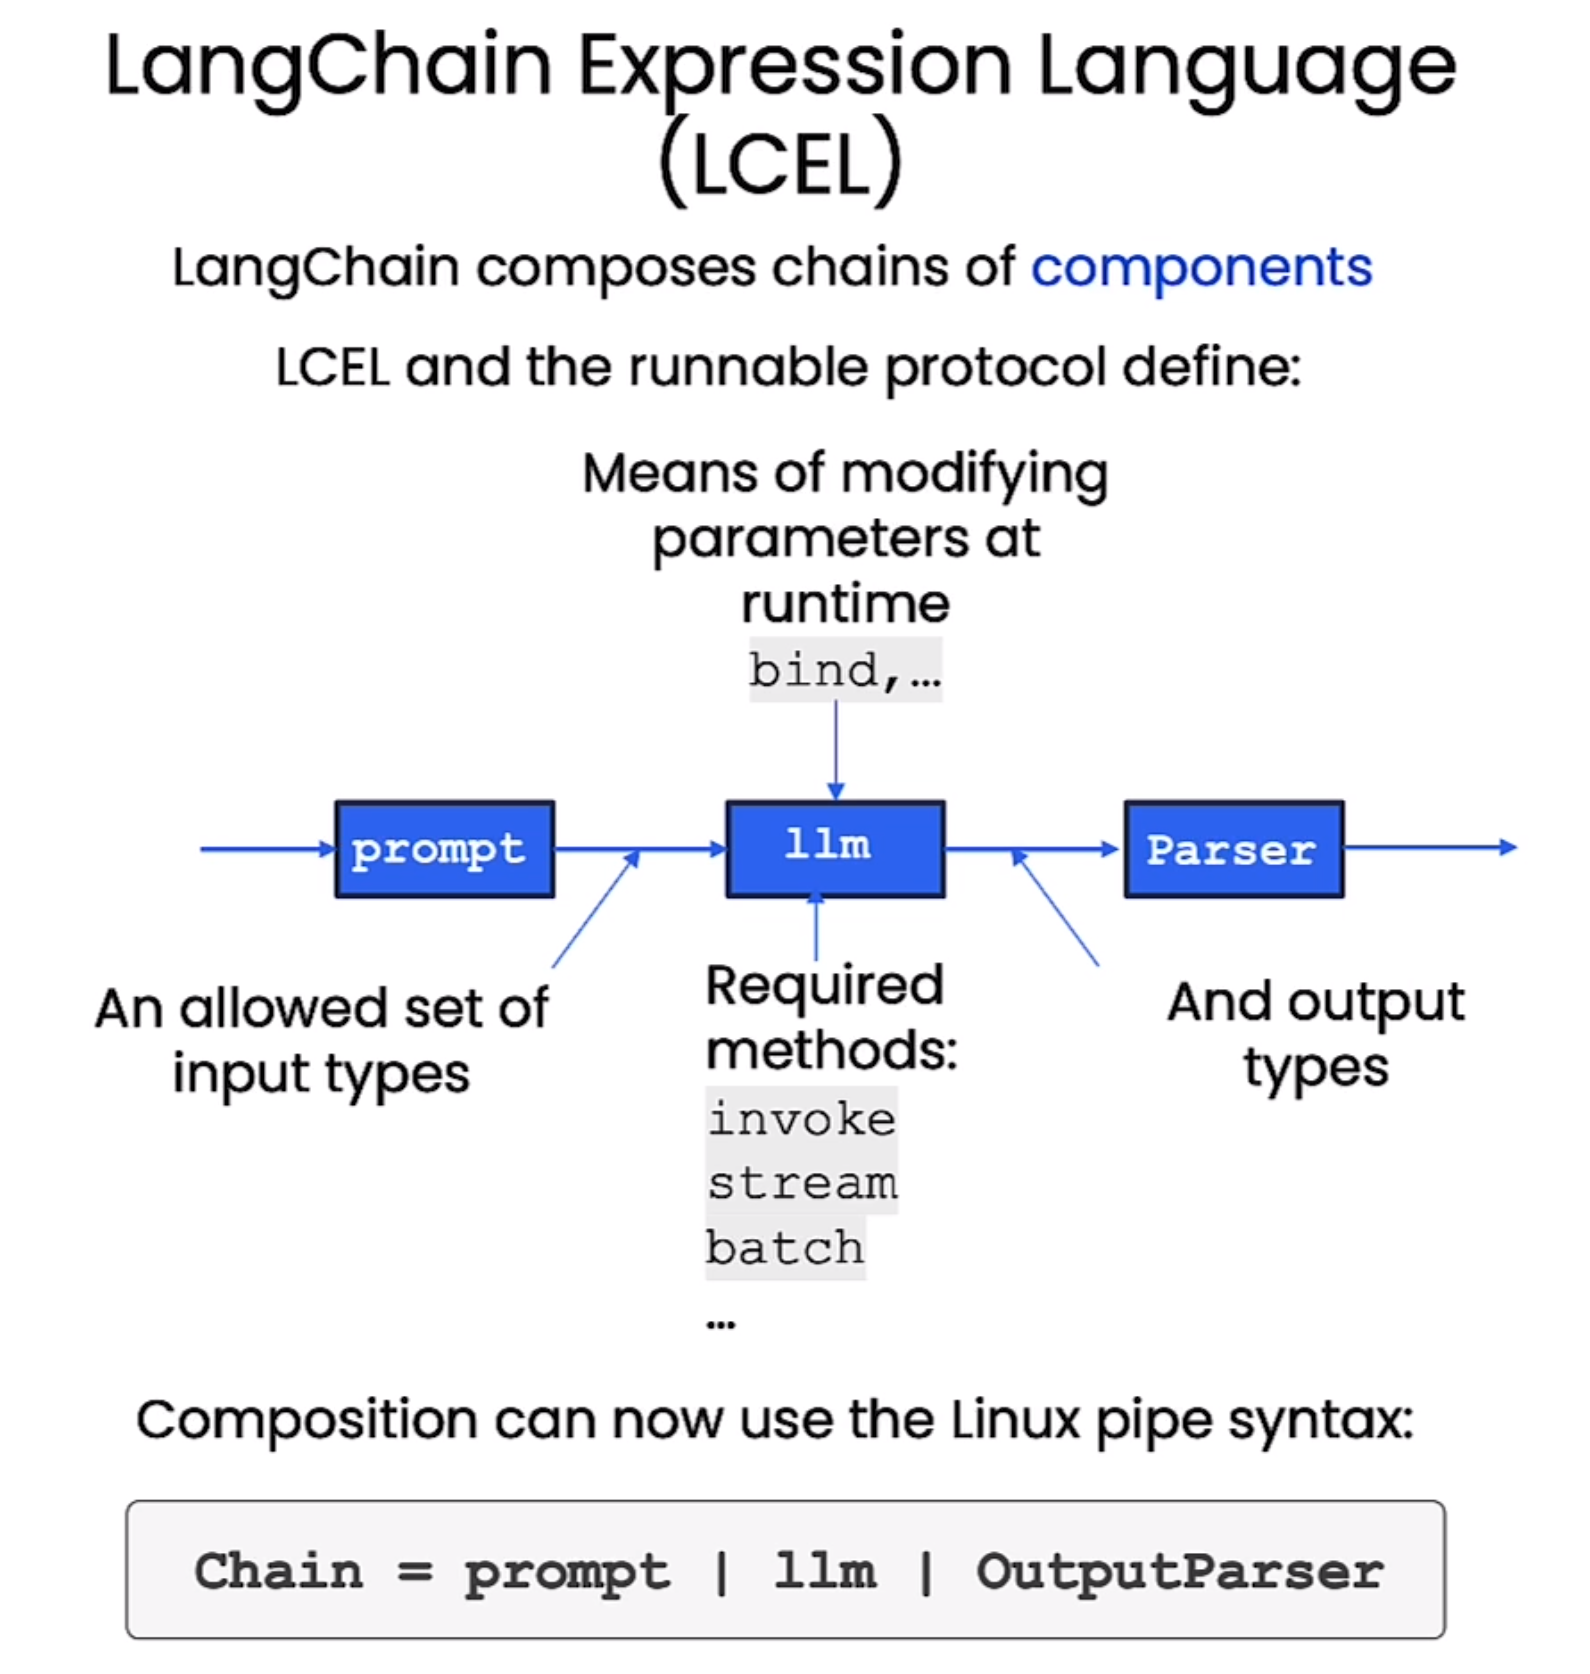

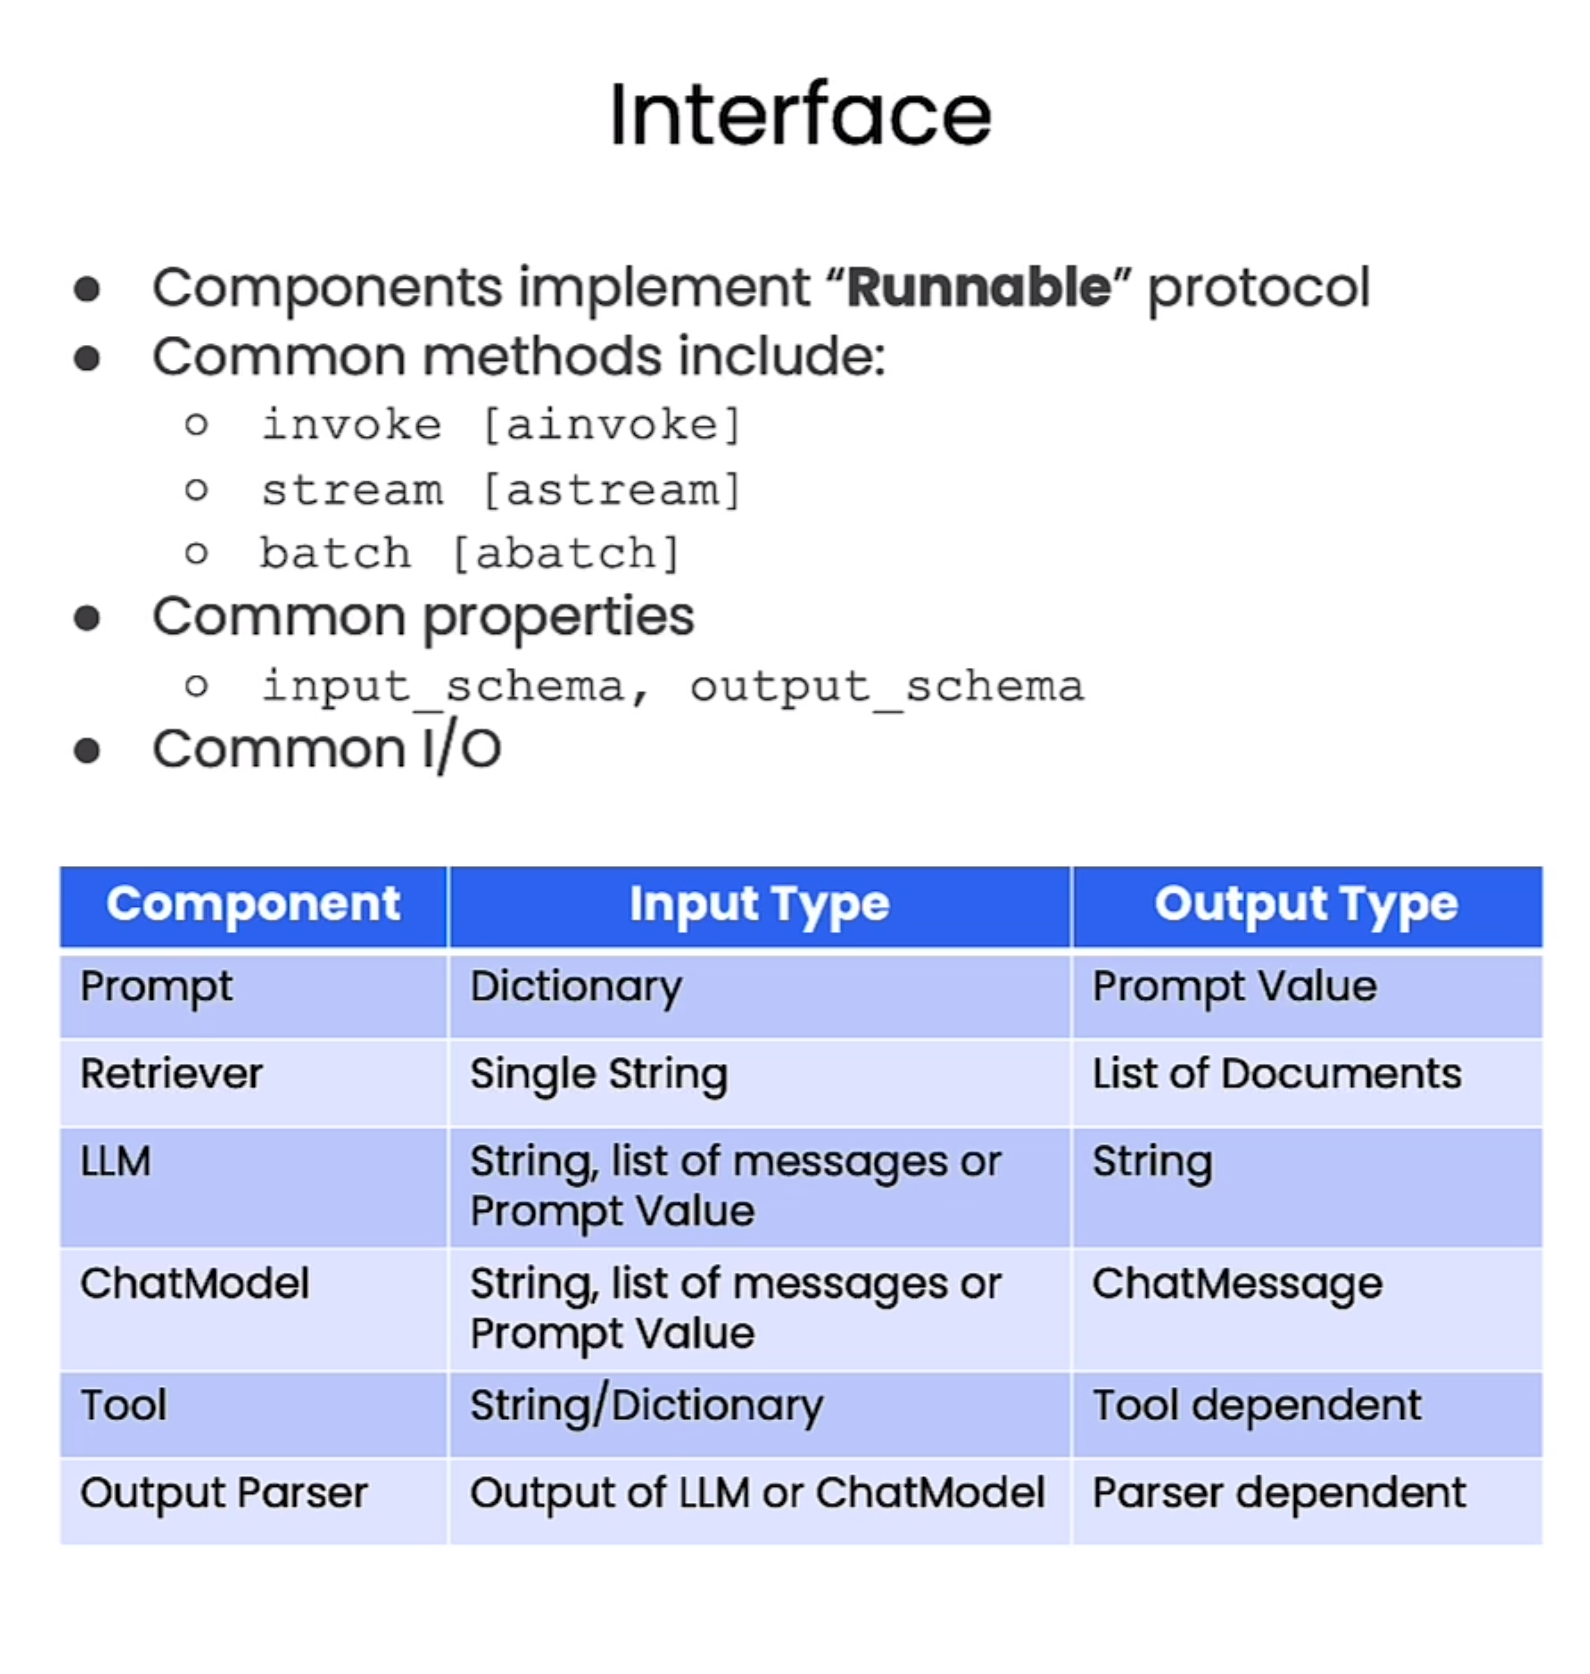

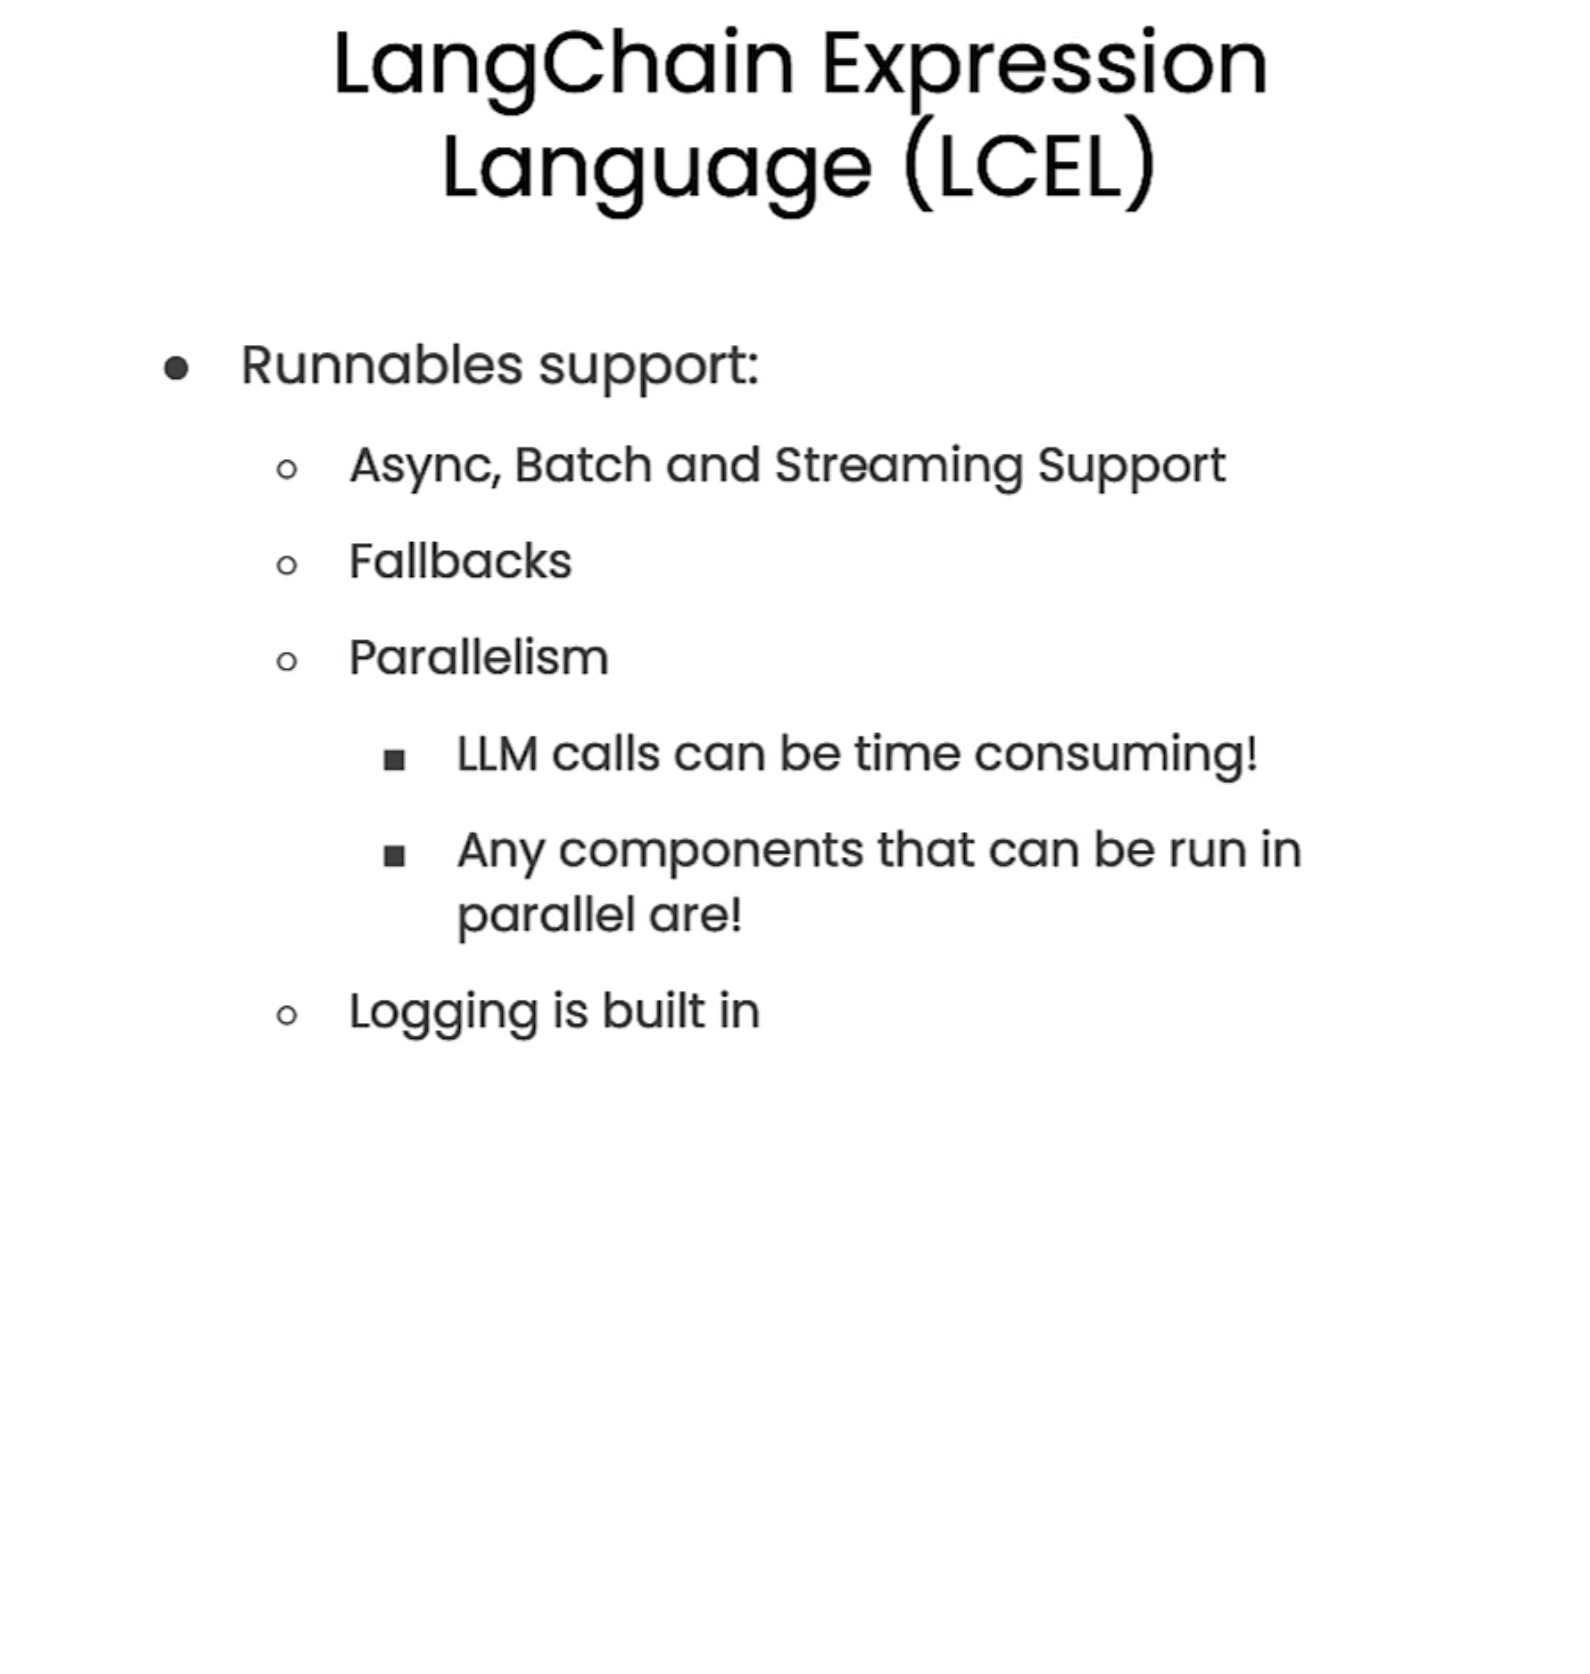

In [1]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
#!pip install pydantic==1.10.8

In [3]:
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

## Simple Chain

In [4]:
prompt = ChatPromptTemplate.from_template(
    "tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

In [5]:
chain = prompt | model | output_parser

In [6]:
chain.invoke({"topic": "bears"})

"Why don't bears wear shoes? \n\nBecause they have bear feet!"

## More complex chain

And Runnable Map to supply user-provided inputs to the prompt.

In [7]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch

In [8]:
vectorstore = DocArrayInMemorySearch.from_texts(
    ["harrison worked at kensho", "bears like to eat honey"], 
    embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [9]:
retriever.get_relevant_documents("where did harrison work?")

[Document(page_content='harrison worked at kensho'),
 Document(page_content='bears like to eat honey')]

In [10]:
retriever.get_relevant_documents("what do bears like to eat") # When used with Large Number of documents, it will retrieve the most similar ones.

[Document(page_content='bears like to eat honey'),
 Document(page_content='harrison worked at kensho')]

In [11]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [12]:
from langchain.schema.runnable import RunnableMap

In [13]:
chain = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
}) | prompt | model | output_parser

In [14]:
chain.invoke({"question": "where did harrison work?"})

'Harrison worked at Kensho.'

In [15]:
inputs = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
})

In [16]:
inputs.invoke({"question": "where did harrison work?"})

{'context': [Document(page_content='harrison worked at kensho'),
  Document(page_content='bears like to eat honey')],
 'question': 'where did harrison work?'}

## Bind

and OpenAI Functions

In [17]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    }
  ]

In [18]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}")
    ]
)
model = ChatOpenAI(temperature=0).bind(functions=functions)

In [19]:
runnable = prompt | model

In [20]:
runnable.invoke({"input": "what is the weather in sf"})

AIMessage(content='', additional_kwargs={'function_call': {'name': 'weather_search', 'arguments': '{\n  "airport_code": "SFO"\n}'}})

In [21]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    },
        {
      "name": "sports_search",
      "description": "Search for news of recent sport events",
      "parameters": {
        "type": "object",
        "properties": {
          "team_name": {
            "type": "string",
            "description": "The sports team to search for"
          },
        },
        "required": ["team_name"]
      }
    }
  ]

In [22]:
model = model.bind(functions=functions)

In [23]:
runnable = prompt | model

In [24]:
runnable.invoke({"input": "how did the patriots do yesterday?"})

AIMessage(content='', additional_kwargs={'function_call': {'name': 'sports_search', 'arguments': '{\n  "team_name": "patriots"\n}'}})

## Fallbacks

In [25]:
from langchain.llms import OpenAI
import json

In [26]:
simple_model = OpenAI(
    temperature=0, 
    max_tokens=1000, 
    model="text-davinci-001"
)
simple_chain = simple_model | json.loads

In [27]:
challenge = "write three poems in a json blob, where each poem is a json blob of a title, author, and first line"

In [28]:
simple_model.invoke(challenge)

'\n\n["The Waste Land","T.S. Eliot","April is the cruelest month, breeding lilacs out of the dead land"]\n\n["The Raven","Edgar Allan Poe","Once upon a midnight dreary, while I pondered, weak and weary"]\n\n["Ode to a Nightingale","John Keats","Thou still unravish\'d bride of quietness, Thou foster-child of silence and slow time"]'

Note: The next line is expected to fail.

In [29]:
simple_chain.invoke(challenge)

JSONDecodeError: Extra data: line 5 column 1 (char 103)

In [30]:
model = ChatOpenAI(temperature=0)
chain = model | StrOutputParser() | json.loads

In [31]:
chain.invoke(challenge)

{'poem1': {'title': 'Whispers of the Wind',
  'author': 'Emily Rivers',
  'first_line': 'Softly it comes, the whisper of the wind'},
 'poem2': {'title': 'Silent Serenade',
  'author': 'Jacob Moore',
  'first_line': 'In the stillness of night, a silent serenade'},
 'poem3': {'title': 'Dancing Shadows',
  'author': 'Sophia Anderson',
  'first_line': 'Shadows dance upon the moonlit floor'}}

In [32]:
final_chain = simple_chain.with_fallbacks([chain])

In [33]:
final_chain.invoke(challenge)

{'poem1': {'title': 'Whispers of the Wind',
  'author': 'Emily Rivers',
  'first_line': 'Softly it comes, the whisper of the wind'},
 'poem2': {'title': 'Silent Serenade',
  'author': 'Jacob Moore',
  'first_line': 'In the stillness of night, a silent serenade'},
 'poem3': {'title': 'Dancing Shadows',
  'author': 'Sophia Anderson',
  'first_line': 'Shadows dance upon the walls, a secret ballet'}}

## Interface

In [34]:
prompt = ChatPromptTemplate.from_template(
    "Tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

chain = prompt | model | output_parser

In [35]:
chain.invoke({"topic": "bears"})

"Why don't bears wear shoes? \n\nBecause they have bear feet!"

In [36]:
chain.batch([{"topic": "bears"}, {"topic": "frogs"}])

["Why don't bears wear shoes?\n\nBecause they have bear feet!",
 'Why don\'t frogs like using smartphones?\n\nBecause they already have plenty of "webbed" feet!']

In [37]:
for t in chain.stream({"topic": "bears"}):
    print(t)


Why
 don
't
 bears
 wear
 shoes
?
 


Because
 they
 have
 bear
 feet
!



In [38]:
response = await chain.ainvoke({"topic": "bears"})
response

"Why don't bears wear shoes?\n\nBecause they have bear feet!"